In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Create an image of the Lorenz attractor.
# The maths behind this code is described in the scipython blog article
# at https://scipython.com/blog/the-lorenz-attractor/
# Christian Hill, January 2016.

# Lorenz paramters and initial conditions
sigma, beta, rho = 10, (8.00/3.00), 28
u0, v0, w0 = 0.1, 1.2, 1.2

In [3]:
tmax, n = 50, 2829

def lorenz(X, t, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

In [4]:
t = np.linspace(0, tmax, n)
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, rho))
x, y, z = f.T

In [5]:
x

array([0.1       , 0.28293775, 0.45446533, ..., 3.90803708, 4.40584166,
       4.97552064])

In [6]:
y

array([1.2       , 1.2699046 , 1.42156093, ..., 6.5365414 , 7.41668948,
       8.41656634])

In [7]:
z

array([ 1.2       ,  1.14886564,  1.10454697, ..., 14.4247027 ,
       14.26098826, 14.24528581])

In [8]:
t

array([0.00000000e+00, 1.76803395e-02, 3.53606789e-02, ...,
       4.99646393e+01, 4.99823197e+01, 5.00000000e+01])

In [10]:
# Import plotting routines
from pylab import *

# The Lorenz 3D ODEs
#	Original parameter values: (sigma,R,b) = (10,28,-8/3)
def LorenzXDot(sigma,R,b,x,y,z):
	return sigma * (-x + y)

def LorenzYDot(sigma,R,b,x,y,z):
	return R*x - x*z - y

def LorenzZDot(sigma,R,b,x,y,z):
	return b*z + x*y

# The tangent space (linearized) flow (aka co-tangent flow)
def LorenzDXDot(sigma,R,b,x,y,z,dx,dy,dz):
	return sigma * (-dx + dy)

def LorenzDYDot(sigma,R,b,x,y,z,dx,dy,dz):
	return (R-z)*dx - dy - x*dz

def LorenzDZDot(sigma,R,b,x,y,z,dx,dy,dz):
	return y*dx + x*dy + b*dz

# Volume contraction given by
#	 Trace(Jacobian(x,y,z)) = b - sigma - 1
def LorenzODETrJac(sigma,R,b,x,y,z):
	return b - sigma - 1
# As a check, we must have total contraction = Sum of LCEs
#	 Tr(J) = Sum_i LCEi
# Numerical check: at (sigma,R,b) = (10,28,-8/3)
#	 LCE0  ~   0.9058
#	 LCE1  ~   0.0000
#	 LCE2  ~ -14.572
#	 Tr(J) ~ -13.6666
# These use base-2 logs

# The fractal dimension from the LCEs (Kaplan-Yorke conjecture)
#   Assume these are ordered: LCE1 >= LCE2 >= LCE3
def FractalDimension3DODE(LCE1,LCE2,LCE3):
	# "Close" to zero ... we're estimating here
	Err = 0.01
	if LCE1 < -Err:	  # Stable fixed point    (-,-,-)
		return 0.0
	elif abs(LCE1) <= Err:
		if LCE2 < -Err:  # Limit cycle	      (0,-,-)
			return 1.0
		else:	        # Torus               (0,0,-)
			return 2.0
	else:	            # Chaotic attractor   (+,0,-)
		return 2.0 + (LCE1+LCE2) / abs(LCE3)

# 3D fourth-order Runge-Kutta integrator
def RKThreeD(a,b,c,x,y,z,f,g,h,dt):
	k1x = dt * f(a,b,c,x,y,z)
	k1y = dt * g(a,b,c,x,y,z)
	k1z = dt * h(a,b,c,x,y,z)
	k2x = dt * f(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k2y = dt * g(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k2z = dt * h(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k3x = dt * f(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k3y = dt * g(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k3z = dt * h(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k4x = dt * f(a,b,c,x + k3x,y + k3y,z + k3z)
	k4y = dt * g(a,b,c,x + k3x,y + k3y,z + k3z)
	k4z = dt * h(a,b,c,x + k3x,y + k3y,z + k3z)
	x += ( k1x + 2.0 * k2x + 2.0 * k3x + k4x ) / 6.0
	y += ( k1y + 2.0 * k2y + 2.0 * k3y + k4y ) / 6.0
	z += ( k1z + 2.0 * k2z + 2.0 * k3z + k4z ) / 6.0
	return x,y,z

# Tanget space flow (using fourth-order Runge-Kutta integrator)
def TangentFlowRKThreeD(a,b,c,x,y,z,df,dg,dh,dx,dy,dz,dt):
	k1x = dt * df(a,b,c,x,y,z,dx,dy,dz)
	k1y = dt * dg(a,b,c,x,y,z,dx,dy,dz)
	k1z = dt * dh(a,b,c,x,y,z,dx,dy,dz)
	k2x = dt * df(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k2y = dt * dg(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k2z = dt * dh(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k3x = dt * df(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k3y = dt * dg(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k3z = dt * dh(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k4x = dt * df(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	k4y = dt * dg(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	k4z = dt * dh(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	dx += ( k1x + 2.0 * k2x + 2.0 * k3x + k4x ) / 6.0
	dy += ( k1y + 2.0 * k2y + 2.0 * k3y + k4y ) / 6.0
	dz += ( k1z + 2.0 * k2z + 2.0 * k3z + k4z ) / 6.0
	return dx,dy,dz

In [23]:
# Simulation parameters
# Integration time step
dt = 0.01
#
# Control parameters for the Lorenz ODEs:
sigma = 10.0
R	  = 28.0
b	  = -8.0/3.0
# The number of iterations to throw away
nTransients = 100
# The number of time steps to integrate over
nIterates = 5000

# The main loop that generates the orbit, storing the states
xState = 5.0
yState = 5.0
zState = 5.0

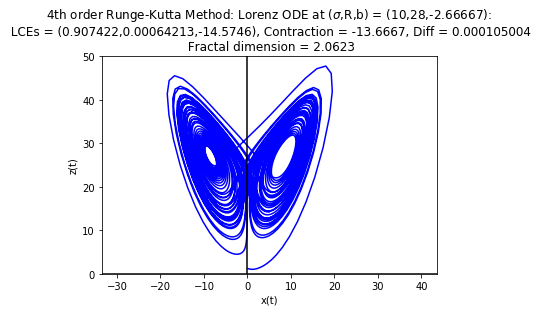

In [25]:
# Estimate the LCEs
# The number of iterations to throw away
nTransients = 100
# The number of iterations to over which to estimate
#  This is really the number of pull-backs
nIterates = 5000
# The number of iterations per pull-back
nItsPerPB = 10
# Initial condition
xState = 5.0
yState = 5.0 
zState = 5.0 
# Initial tangent vectors
e1x = 1.0
e1y = 0.0
e1z = 0.0
e2x = 0.0
e2y = 1.0
e2z = 0.0
e3x = 0.0
e3y = 0.0
e3z = 1.0
# Iterate away transients and let the tangent vectors align
#	with the global stable and unstable manifolds
for n in range(0,nTransients):
	for i in range(nItsPerPB):
		xState,yState,zState = RKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzXDot,LorenzYDot,LorenzZDot,dt)
		# Evolve tangent vector for maximum LCE (LCE1)
		e1x,e1y,e1z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e1x,e1y,e1z,dt)
		# Evolve tangent vector for next LCE (LCE2)
		e2x,e2y,e2z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e2x,e2y,e2z,dt)
		# Evolve tangent vector for last LCE
		e3x,e3y,e3z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e3x,e3y,e3z,dt)
	# Normalize the tangent vector
	d = sqrt(e1x*e1x + e1y*e1y + e1z*e1z)
	e1x /= d
	e1y /= d
	e1z /= d
	# Pull-back: Remove any e1 component from e2
	dote1e2 = e1x * e2x + e1y * e2y + e1z * e2z
	e2x -= dote1e2 * e1x
	e2y -= dote1e2 * e1y
	e2z -= dote1e2 * e1z
	# Normalize second tangent vector
	d = sqrt(e2x*e2x + e2y*e2y + e2z*e2z)
	e2x /= d
	e2y /= d
	e2z /= d
	# Pull-back: Remove any e1 and e2 components from e3
	dote1e3 = e1x * e3x + e1y * e3y + e1z * e3z
	dote2e3 = e2x * e3x + e2y * e3y + e2z * e3z
	e3x -= dote1e3 * e1x + dote2e3 * e2x
	e3y -= dote1e3 * e1y + dote2e3 * e2y
	e3z -= dote1e3 * e1z + dote2e3 * e2z
	# Normalize third tangent vector
	d = sqrt(e3x*e3x + e3y*e3y + e3z*e3z)
	e3x /= d
	e3y /= d
	e3z /= d

# Okay, now we're ready to begin the estimation
LCE1 = 0.0
LCE2 = 0.0
LCE3 = 0.0
for n in range(0,nIterates):
	for i in range(nItsPerPB):
		xState,yState,zState = RKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzXDot,LorenzYDot,LorenzZDot,dt)
		# Evolve tangent vector for maximum LCE (LCE1)
		e1x,e1y,e1z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e1x,e1y,e1z,dt)
		# Evolve tangent vector for next LCE (LCE2)
		e2x,e2y,e2z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e2x,e2y,e2z,dt)
		# Evolve tangent vector for last LCE
		e3x,e3y,e3z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e3x,e3y,e3z,dt)
	# Normalize the tangent vector
	d = sqrt(e1x*e1x + e1y*e1y + e1z*e1z)
	e1x /= d
	e1y /= d
	e1z /= d
	# Accumulate the first tangent vector's length change factor
	LCE1 += log(d)
	# Pull-back: Remove any e1 component from e2
	dote1e2 = e1x * e2x + e1y * e2y + e1z * e2z
	e2x -= dote1e2 * e1x
	e2y -= dote1e2 * e1y
	e2z -= dote1e2 * e1z
	# Normalize second tangent vector
	d = sqrt(e2x*e2x + e2y*e2y + e2z*e2z)
	e2x /= d
	e2y /= d
	e2z /= d
	# Accumulate the second tangent vector's length change factor
	LCE2 += log(d)
	# Pull-back: Remove any e1 and e2 components from e3
	dote1e3 = e1x * e3x + e1y * e3y + e1z * e3z
	dote2e3 = e2x * e3x + e2y * e3y + e2z * e3z
	e3x -= dote1e3 * e1x + dote2e3 * e2x
	e3y -= dote1e3 * e1y + dote2e3 * e2y
	e3z -= dote1e3 * e1z + dote2e3 * e2z
	# Normalize third tangent vector
	d = sqrt(e3x*e3x + e3y*e3y + e3z*e3z)
	e3x /= d
	e3y /= d
	e3z /= d
	# Accumulate the third tangent vector's length change factor
	LCE3 += log(d)

# Convert to per-iterate, per-second LCEs and to base-2 logs
IntegrationTime = dt * float(nItsPerPB) * float(nIterates)
LCE1 = LCE1 / IntegrationTime
LCE2 = LCE2 / IntegrationTime
LCE3 = LCE3 / IntegrationTime
# Calculate contraction factor, for comparison.
#	For Lorenz ODE, we know this is independent of (x,y,z).
#	Otherwise, we'd have to estimate it along the trajectory, too.
Contraction = LorenzODETrJac(sigma,R,b,0.0,0.0,0.0)

# Choose a pair of coordinates from (x,y,z) to show
# Setup the parametric plot:
xlabel('x(t)') # set x-axis label
ylabel('z(t)') # set y-axis label
# Construct plot title
LCEString = '(%g,%g,%g)' % (LCE1,LCE2,LCE3)
PString = '($\sigma$,R,b) = (%g,%g,%g)' % (sigma,R,b)
CString = 'Contraction = %g, Diff = %g' % (Contraction,abs(LCE1+LCE2+LCE3-Contraction))
FString   = 'Fractal dimension = %g' % FractalDimension3DODE(LCE1,LCE2,LCE3)
title('4th order Runge-Kutta Method: Lorenz ODE at ' + PString + ':\n LCEs = ' + LCEString + ', ' + CString + '\n ' + FString)
axis('equal')
axis([-20.0,30.0,0.0,50.0])
# Plot the trajectory in the phase plane
plot(x,z,'b')
axhline(0.0,color = 'k')
axvline(0.0,color = 'k')

# Use command below to save figure
#savefig('LorenzODELCE', dpi=600)

# Display the plot in a window
show()

In [26]:
import pandas as pd
df= pd.DataFrame()
df['t'] =t
df['x'] = x
df['y'] = y
df['z'] = z

In [16]:
df

t         x         y          z
0      0.000000  0.100000  1.200000   1.200000
1      0.017680  0.282938  1.269905   1.148866
2      0.035361  0.454465  1.421561   1.104547
3      0.053041  0.629338  1.651993   1.068062
4      0.070721  0.819981  1.964540   1.041484
...         ...       ...       ...        ...
2824  49.929279  3.093424  5.105041  15.097413
2825  49.946959  3.473470  5.769022  14.710226
2826  49.964639  3.908037  6.536541  14.424703
2827  49.982320  4.405842  7.416689  14.260988
2828  50.000000  4.975521  8.416566  14.245286

[2829 rows x 4 columns]